# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic desgin of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title begins with `Student` and/or is **<font color='orange'>written in orange</font>**, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* The addition of imports is not allowed. Everything must be solved with the ones done in `Teacher: Initialization`.
* **<font color='orange'>Please enter your full names in the next cell in this section and run it BEFORE going any further.</font>**

The practice is designed to be done in **Google Colab**. You can find multiple tutorials on Google Colab and Pandas in Moodle.

The dataset to be used (**available on Moodle**) was extracted from [this website](https://www.kaggle.com/datasets/mfarhaannazirkhan/heart-dataset). **The task is to predict the `sex` attribute using all other attributes (except `target`) as inputs.** The `target` attribute cannot be used in any case, neither as input nor as ground truth.


## Deliverable
It is a practice **in pairs**. The students only need to deliver **this notebook** including the answers. The file must have as name `P3_[NameSurnames1]-[NameSurnames2].ipynb`, replacing `[NameSurnames1]` and `[NameSurnames2]` with those from the students.

## Evaluation
To be accepted, all practices delivered must contain **the two solutions with different preprocessing steps** and **the solution with a non-basic MLP**.

**All text must be written in English.**

<font color='red'>**Similar or identical practices will get a grade of 0.**</font>

In [ ]:
STUDENT_NAMES = "LYUBOMYR GRYGORIV LVIVSKA && SATXA FORTUNY PIMENTEL" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [ ]:
import pandas as pd
import numpy as np
from hashlib import sha256

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for faster training (and prediction).

In [ ]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is no GPU available, using CPU.


# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
The `data_loading` function loads a `.csv` file (such as that available on Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 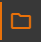. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends). To be used in the [Exploratory data analysis](#data_analysis) section.

The dataframe to be used in practice is a pseudo-random subset of the full dataset, **different from that of other students**.

In [ ]:
LABEL_COL_NAME = "sex" # Global constant


def data_loading(file_name:str):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["target"]) # Remove some columns that CANNOT be used # TODO

  # Manage the unbalance of the LABEL_COL
  original_df = balance_df(original_df, LABEL_COL_NAME, 1.8)

  # Renaming of number-coded categories to category name
  mapping = {"sex": {"0":"Female", "1":"Male"},
             "cp": {"0":"Typical angina", "1":"Atypical angina", "2":"Non-anginal pain", "3":"Asymptomatic", "4":"Unknown"},
             "fbs":{"0":"<=120mg/dl", "1":">120mg/dl"},
             "restecg":{"0":"Normal", "1":"ST-T wave abnormality", "2":"Left ventricular hypertrophy"},
             "exang":{"0":"Yes", "1":"No"},
             "slope":{"0":"Upsloping", "1":"Flat", "2":"Downsloping", "3":"Unknown"},
             "thal":{"0":"Normal", "1":"Fixed defect", "2":"Reversible defect", "3":"Type 3", "6":"Type 6", "7":"Type 7"}}
  for col_name, maps in mapping.items():
    original_df[col_name] = original_df[col_name].astype(str)
    for old_value, new_value in maps.items():
        original_df.loc[original_df[col_name] == old_value, col_name] = new_value

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac = 1/3
  names_hash = int.from_bytes(bytearray(sha256(STUDENT_NAMES.encode('utf-8')).digest()), byteorder='big')
  random_seed = names_hash % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df


def balance_df(df:pd.DataFrame, label_col_name:str, ratio:float) -> pd.DataFrame:
    # Count the occurrences of each value in the column
    value_counts = df[label_col_name].value_counts()

    # Identify the majority and minority classes
    majority_class = value_counts.idxmax()
    minority_class = value_counts.idxmin()

    majority_count = value_counts[majority_class]
    minority_count = value_counts[minority_class]

    # Determine how many rows to drop
    target_majority_count = int(ratio*minority_count)
    excess_majority_count = max(0, majority_count - target_majority_count)

    # Retain only the first rows of the majority class
    balanced_df = df.copy()
    balanced_majority = balanced_df[balanced_df[label_col_name] == majority_class].iloc[:target_majority_count]
    balanced_rest = balanced_df[balanced_df[label_col_name] != majority_class]

    # Concatenate to get the final balanced DataFrame
    balanced_df = pd.concat([balanced_majority, balanced_rest]).reset_index(drop=True)

    return balanced_df

## Analysis
Functions that facilitate the data distribution analysis. The functions receive the Panda's dataframe and the name of the column (or columns) to consider. To be used in the [Exploratory data analysis](#data_analysis) section.

In [ ]:
def feature_histogram(df:pd.DataFrame, column_name:str):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()


def feature_stats(df:pd.DataFrame, column_name:str, verbose:bool=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  else:
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats


def features_relationship(df:pd.DataFrame, column_name_1:str, column_name_2:str):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.hexbin(data1, data2, gridsize=30, cmap='Blues', mincnt=1) # Use hexbin for visibility of overlaps
        plt.colorbar(label='Count')
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif not pd.api.types.is_numeric_dtype(data1) and not pd.api.types.is_numeric_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_numeric_dtype(data1):
            categorical_column = column_name_2
            numerical_column = column_name_1
        else:
            categorical_column = column_name_1
            numerical_column = column_name_2

        # Plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=categorical_column, y=numerical_column, data=df)
        plt.title(f'Relationship between {categorical_column} and {numerical_column}')
        plt.xticks(rotation=45)
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed Pandas' dataframe into the training and test datasets, both using the PyTorch's TensorDataset class. To be used in the [Experiments](#experiments) section.

In [ ]:
def df_to_dataset(preprocessed_df:pd.DataFrame, label_col_name:str=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model **instanciation** and allocation in **DEVICE** (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [ ]:
def create_model(model_class, input_size:int, num_classes:int, verbose:bool=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [ ]:
def train(model:nn.Module, train_dataset:Dataset, test_dataset:Dataset, num_epochs:int, lr:float):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloaders with hard-coded batch size
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Set up loss evolution plot
    train_losses = []
    test_losses = []

    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Loss Evolution')

    train_line, = ax.plot([], [], label='Training Loss', color='blue')
    test_line, = ax.plot([], [], label='Test Loss', color='orange')
    ax.legend()

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation phase
        mean_train_loss = loss_of_dataloader(model, train_loader, criterion)
        train_losses.append(mean_train_loss)
        mean_test_loss = loss_of_dataloader(model, test_loader, criterion)
        test_losses.append(mean_test_loss)

        # Update plot
        train_line.set_ydata(train_losses)
        train_line.set_xdata(range(1, len(train_losses) + 1))

        test_line.set_ydata(test_losses)
        test_line.set_xdata(range(1, len(test_losses) + 1))

        ax.relim()
        ax.autoscale_view()

        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Training Loss: {mean_train_loss:.4f} (starting at {train_losses[0]:.4f}) | Test Loss: {mean_test_loss:.4f} (starting at {test_losses[0]:.4f})')

    # Turn off interactive mode
    plt.ioff()
    plt.close()

    return train_losses, test_losses

def loss_of_dataloader(model:nn.Module, dataloader:DataLoader, criterion):
    total_loss = 0.0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * len(inputs) # Avg. loss * #samples
            num_samples += len(inputs)
    model.train()

    mean_loss = total_loss / num_samples

    return mean_loss


## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the evaluation of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [ ]:
def full_evaluation(model:nn.Module, train_dataset:Dataset, test_dataset:Dataset, label_encoder:LabelEncoder):
    train_accuracy, _, _ = evaluate(model, train_dataset)
    test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

    print(f'Train accuracy: {train_accuracy*100:.2f}%')
    print(f'Test accuracy: {test_accuracy*100:.2f}%')

    plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

    return train_accuracy, test_accuracy, test_all_targets, test_all_predicted


def evaluate(model:nn.Module, dataset:Dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets:np.array, all_predicted:np.array, label_encoder:LabelEncoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# <font color='orange'>Student: Exploratory data analysis</font>
<a name="data_analysis"></a>

<font color='orange'>In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.
</font>

In [ ]:
# TODO: YOUR CODE HERE

In [ ]:
# TODO: YOUR CODE HERE
df = data_loading('cleaned_merged_heart_dataset.csv')
df1 = balance_df(df, "sex", 1.0)
# df1 = df

## Analyze each feature
Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.

### AGE

Stats of age: Min=29 | Max=77 | Mean=54.36976320582878 | Std=9.208447612142773 |


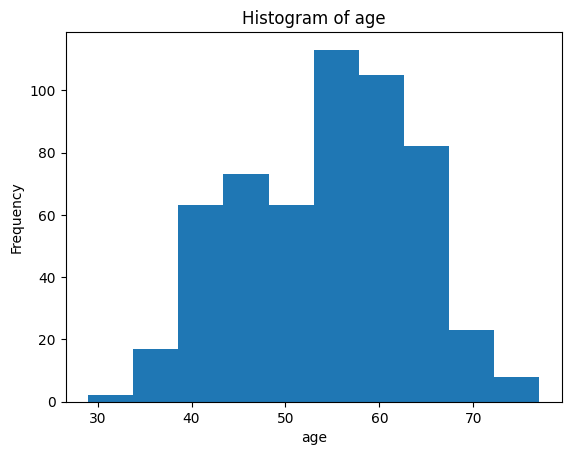

In [ ]:
g11 = feature_stats(df, 'age')
g12 = feature_histogram(df, 'age')

This graphic is not symmetrical and not uniform. We observe we have more cases in the range of 55 and 64 and low cases under 40 and above 68 years. This can affect the model because we don't have many young and old people.

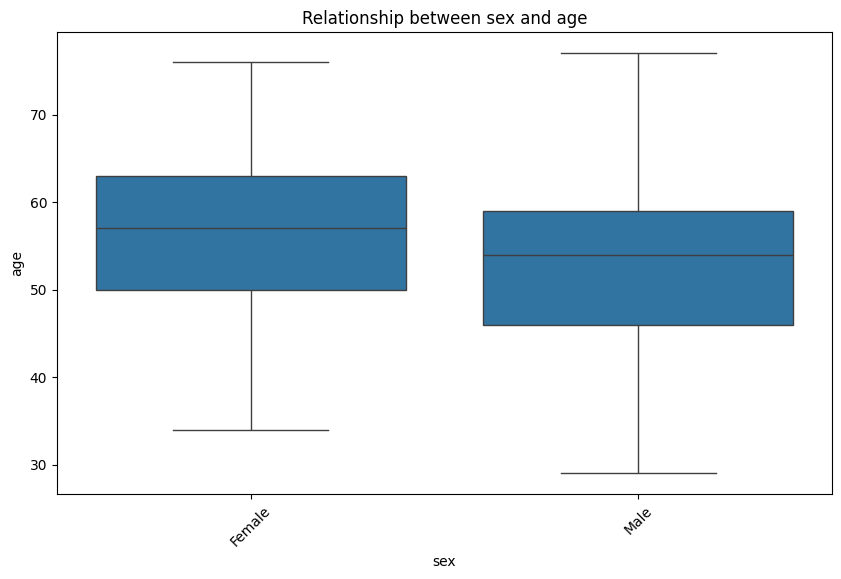

In [ ]:
g13 = features_relationship(df, 'age', 'sex')

In this graphic we observed the relationship between age and sex. In the two cases, we have similar medians but females have more age in promedian. In the case of the male, we have a wider range of ages.

### SEX

Stats of sex: Unique=sex
Male      351
Female    198
Name: count, dtype: int64 |


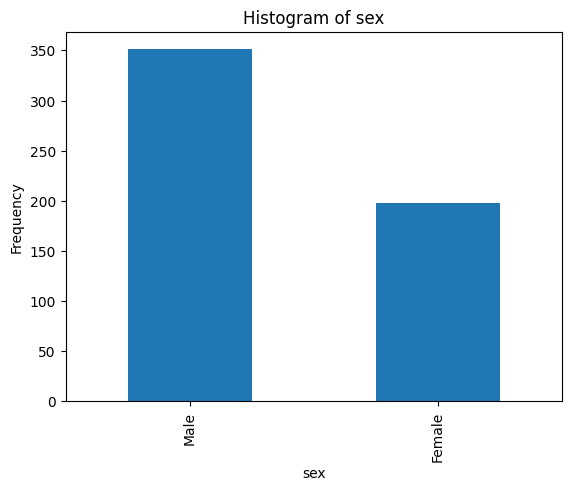

In [ ]:
g21 = feature_stats(df, 'sex')
g22 = feature_histogram(df, 'sex')

According to the stats and the previous graphic, in the database we have more cases of males than females. This is the target attribute, so this imbalance of cases can affect negatively our model.

### CP


Stats of cp: Unique=cp
Typical angina      210
Non-anginal pain    156
Atypical angina      85
Asymptomatic         63
Unknown              35
Name: count, dtype: int64 |


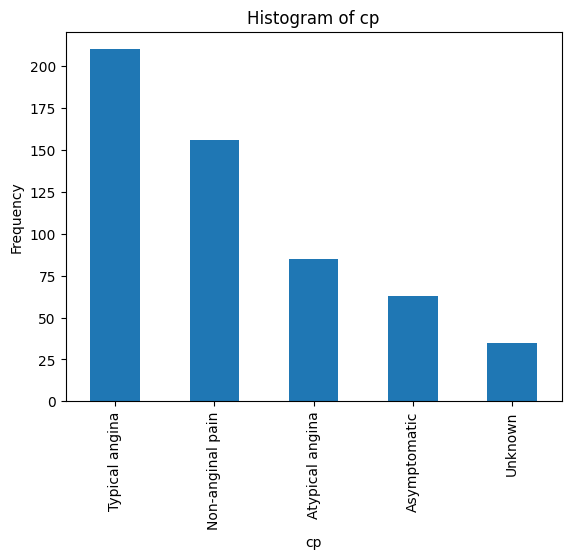

In [ ]:
g31 = feature_stats(df, 'cp')
g32 = feature_histogram(df, 'cp')

The distribution of the graphic is significate imbalanced. We observe two predominate categories (Typical angina and non-anginal pain) wich account to the for mojority of the cases. In contrast, Atypical angina, Asymtomatic and Unknown have significantly fewer cases.

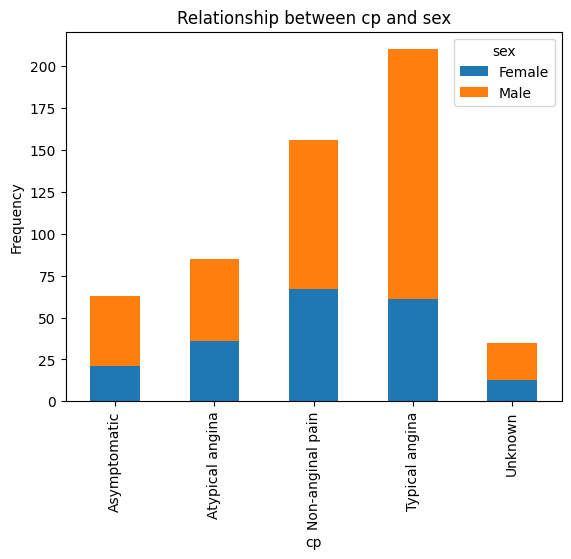

In [ ]:
g33 = features_relationship(df, 'cp', 'sex')

In this graphic we observed the relationship between cp and sex. In almost all the categories of cp the number of males is slightty higher than females. This bahavior is normal because we have more male cases. In the category of Typical angina, we have significantly more cases of males.

### TRESTBPS

Stats of trestbps: Min=94 | Max=200 | Mean=131.36429872495447 | Std=18.352943848620043 |


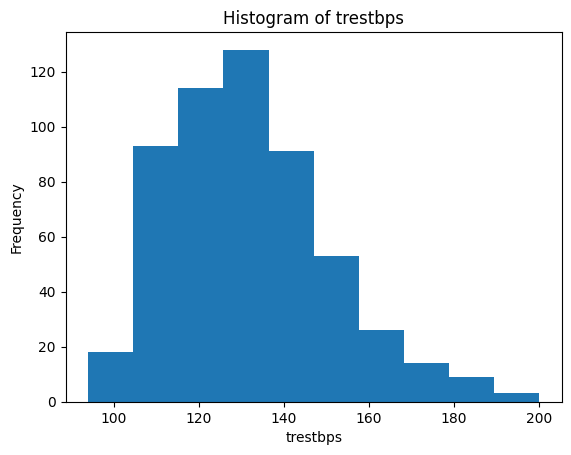

In [ ]:
g41 = feature_stats(df, 'trestbps')
g42 = feature_histogram(df, 'trestbps')

The graphic is unbalanced, the majority of the cases are in the range of 105 and 145 (approx). In the right part of the graphic, we can see as we increase the value of trestbps, the cases decrease.

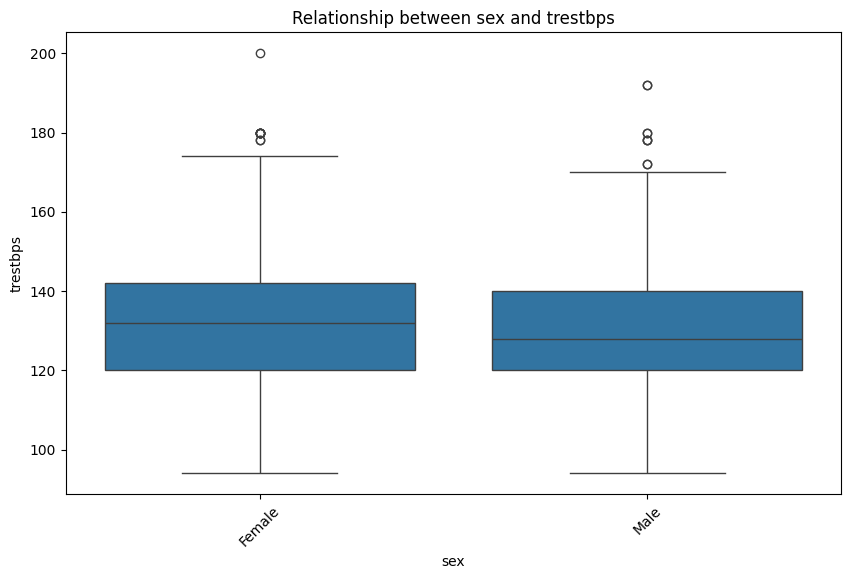

In [ ]:
g43 = features_relationship(df1, 'trestbps', 'sex')

In this graphic we observed the relationship between trestbps and sex. In this case, we have almost the same median and the same range, females have a little bit more in the two cases.
Also, we have many atypical values; both male and female have one value very dispersed. This values can affect negativently to our model.

### CHOL

Stats of chol: Min=126 | Max=564 | Mean=249.24043715846994 | Std=58.03240131795555 |


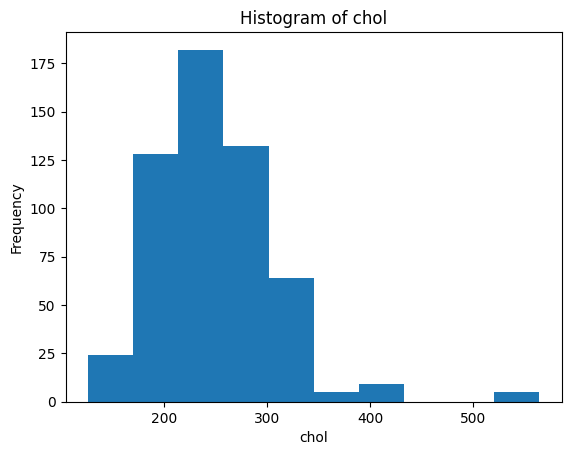

In [ ]:
g51 = feature_stats(df, 'chol')
g52 = feature_histogram(df, 'chol')

This graphic is asymmetrical but has a distribution like a bell (similar to normal distribution). Also, it is not continious, we don't have cases in the range of 430 and 510 (approx.). In contrast we, have few cases above 510, this could negatively affect the model.

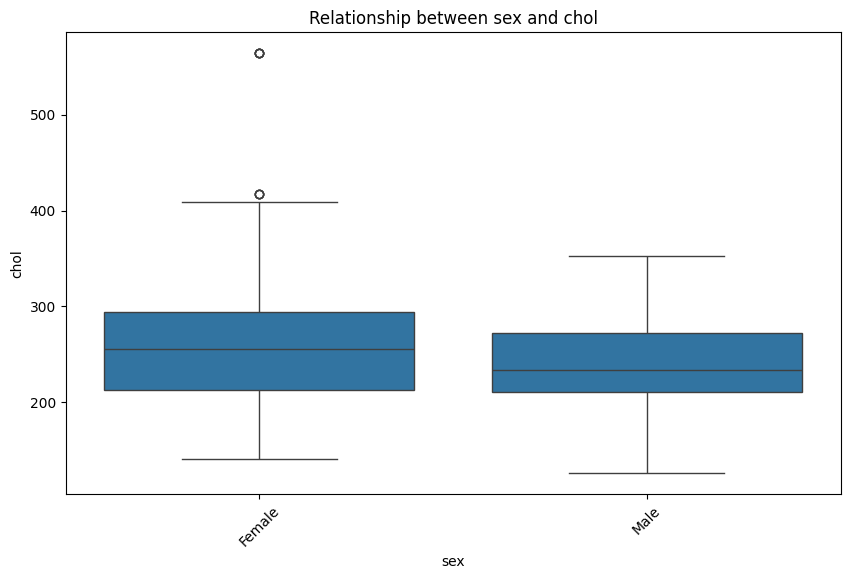

In [ ]:
g53 = features_relationship(df, 'chol', 'sex')

In this graphic we observed the relationship between chol and sex. In this case, we observe that females have a bigger range of values and slightly higher median value than male. In the other side, only females have an atypical value, so we can think that this attribute can be important in the prediction if the input case has a high value (in this attibute).

### FBS

Stats of fbs: Unique=fbs
<=120mg/dl    465
>120mg/dl      84
Name: count, dtype: int64 |


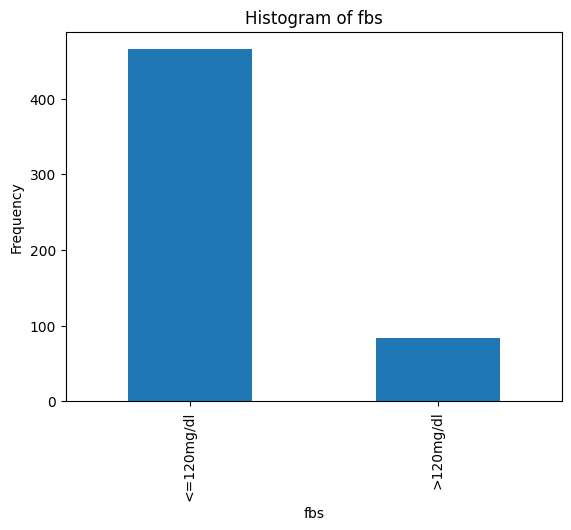

In [ ]:
g61 = feature_stats(df, 'fbs')
g62 = feature_histogram(df, 'fbs')

In this case, we only have two different categories, and one of them has the majority of the cases, so we can conclude that the graphic is totally unbalanced. This difference can make us think about if this attribute is necessary for the model.

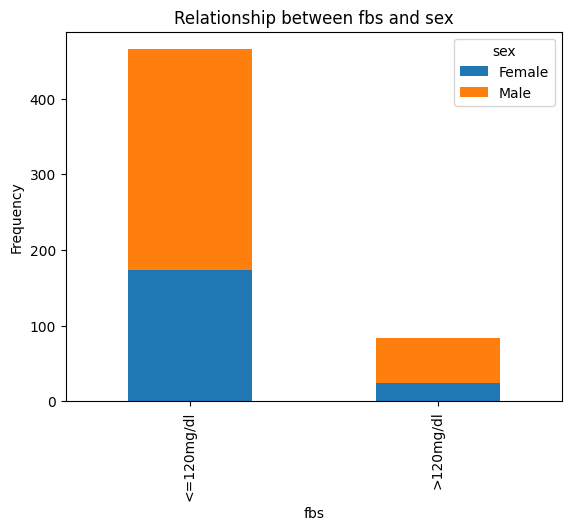

In [ ]:
g63 = features_relationship(df, 'fbs', 'sex')

In this graphic we observed the relationship between fbs and sex. We observe that in the two cases, we have more males than females, but remember we have more cases in one of the classes than the other one. We can balance the dataset to see what happens:

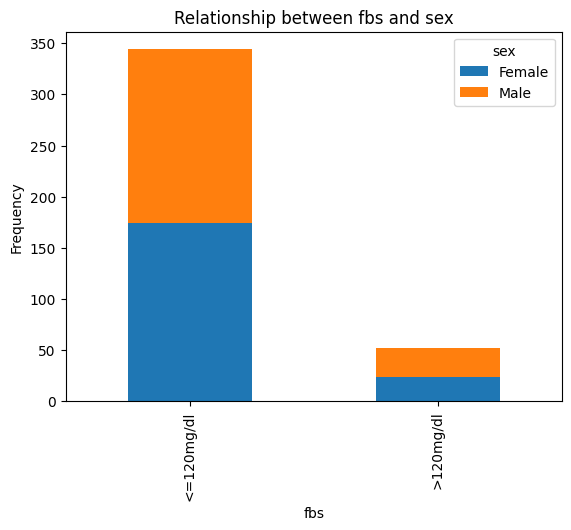

In [ ]:
g64 = features_relationship(df1, 'fbs', 'sex')

We have the same number of males and females in the two categories, so we can think that this attribute isn't necessary in the model.

### RESTECG

Stats of restecg: Unique=restecg
Normal                          280
ST-T wave abnormality           228
Left ventricular hypertrophy     41
Name: count, dtype: int64 |


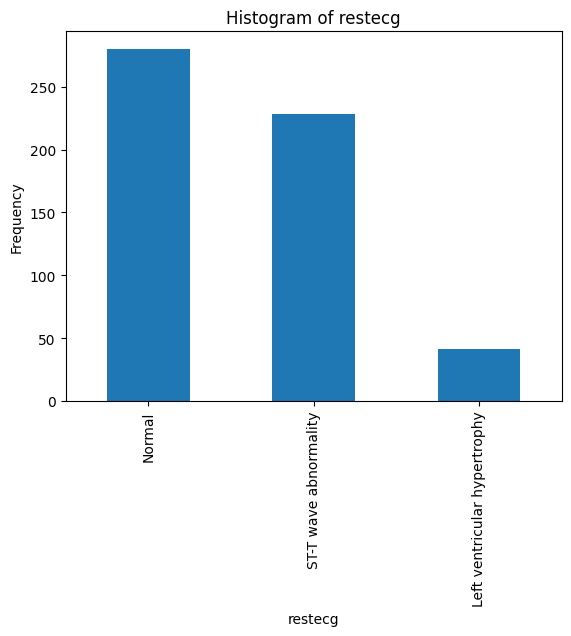

In [ ]:
g71 = feature_stats(df, 'restecg')
g72 = feature_histogram(df, 'restecg')

We observe the graphic is unbalanced. We have 3 categories, where two of them have the majority of the cases.

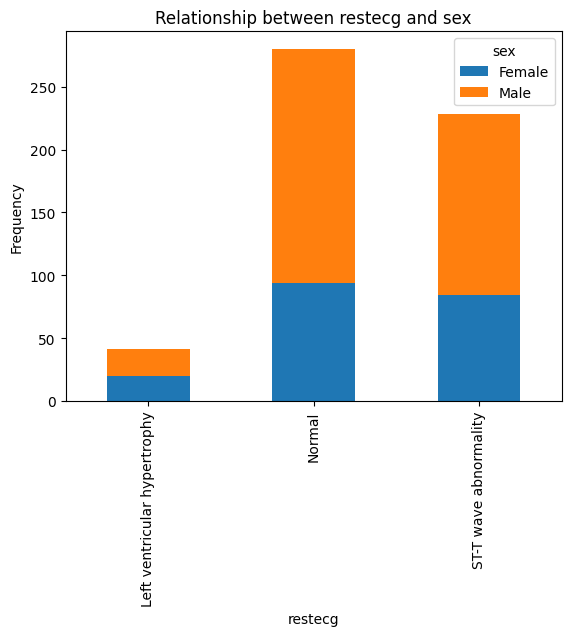

In [ ]:
g73 = features_relationship(df, 'restecg', 'sex')

In this graphic we observed the relationship between restecg and sex. In the majority categories we observe that we have more males than females, but in the minority, it has approximately the same number of the two classes. We can balance the data set to see what happens:

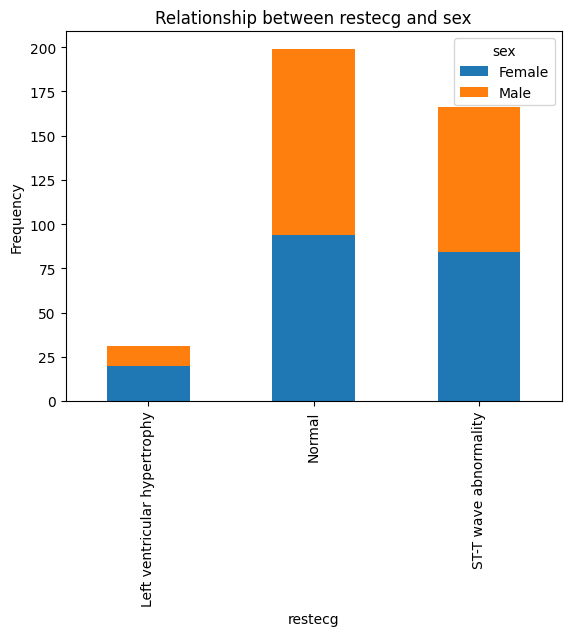

In [ ]:
g73 = features_relationship(df1, 'restecg', 'sex')

In the balanced graphic, we can see that the majority categories have approximately the same number of the two classes, but in the minority, we have more females. This means that if the input case has this minority categorical attribute, the model could predict that it is a female.

### THALACHH

Stats of thalachh: Min=71 | Max=202 | Mean=149.85245901639345 | Std=22.75444326467404 |


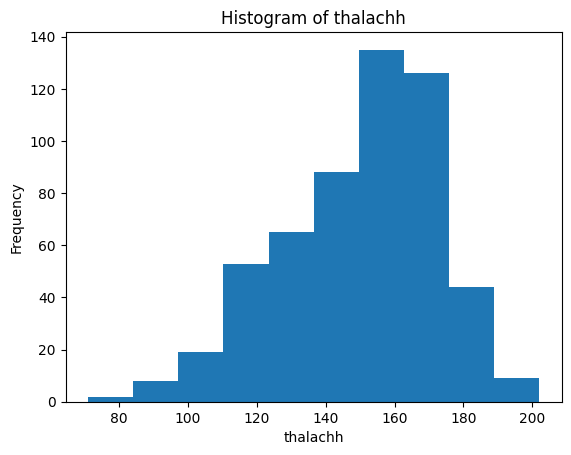

In [ ]:
g81 = feature_stats(df, 'thalachh')
g82 = feature_histogram(df, 'thalachh')

This graphic is unbalanced and asymmetric and has form of a bell. We can see that we have more cases in the range of above 150 and lower than 165 (approx.). In left of this majority, we have a lot of cases of different values, increasing the number of cases as we increase the range value. In contrast, the right site has fewer cases.

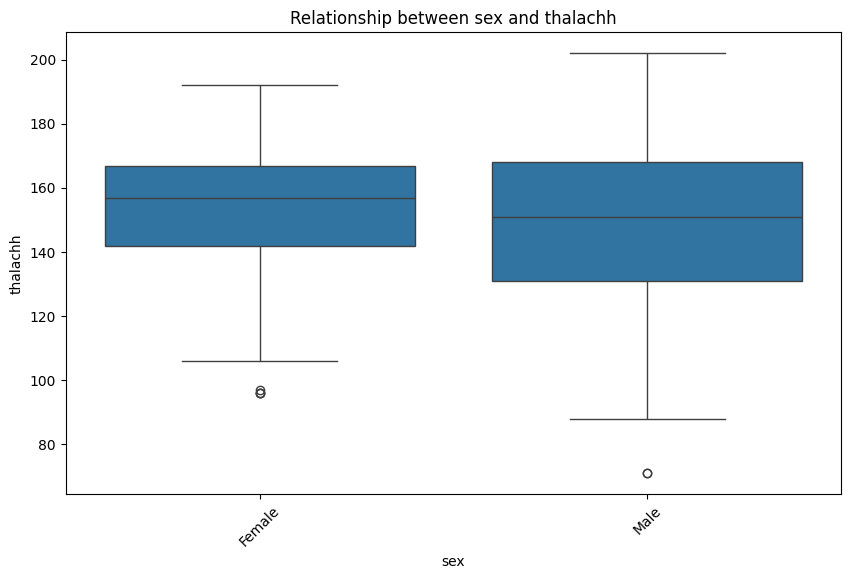

In [ ]:
g83 = features_relationship(df, 'thalachh', 'sex')

In this graphic we observed the relationship between thalachh and sex. In the case of the male, we have a igger range of values and lower media than females and an atypic value (lower respect to the range). In the other case, females have various atypical values, but they are in the range of males' block.

### EXANG

Stats of exang: Unique=exang
Yes    364
No     185
Name: count, dtype: int64 |


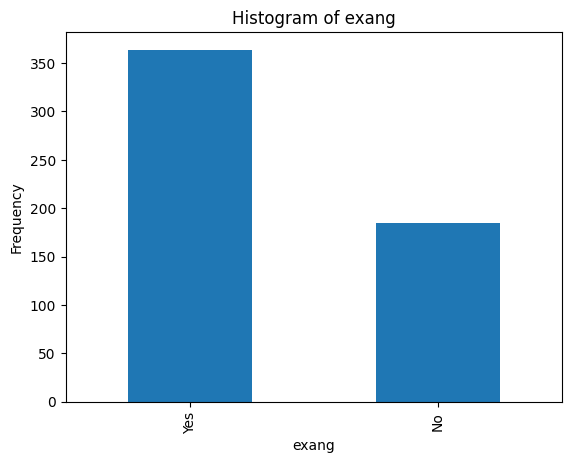

In [ ]:
g91 = feature_stats(df, 'exang')
g92 = feature_histogram(df, 'exang')

In this case we have an unbalanced graphic. We have twice of many cases on one category than the other one (approx.).

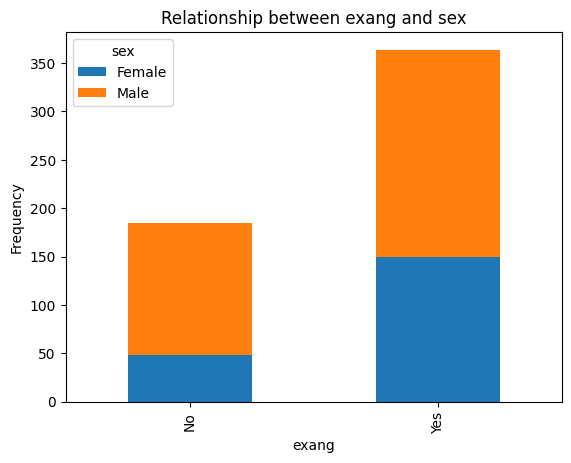

In [ ]:
g93 = features_relationship(df, 'exang', 'sex')

In this graphic we observed the relationship between exang and sex. In the two categories, we have more male cases. This happens because we have the database unbalanced.

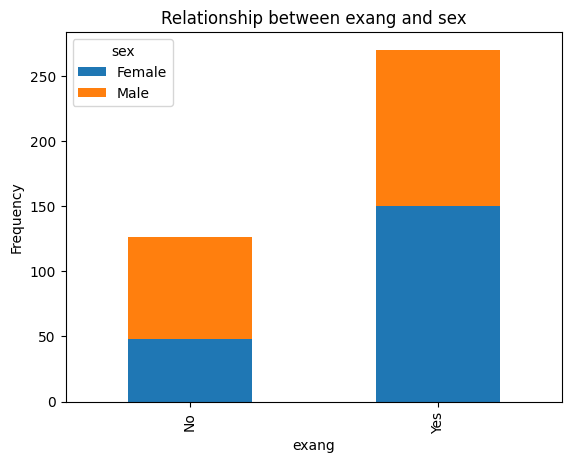

In [ ]:
g93 = features_relationship(df1, 'exang', 'sex')

In the balanced graphic we observed something different. In the category of *YES* we have more females than males.

### OLDPEAK

Stats of oldpeak: Min=0.0 | Max=6.2 | Mean=1.036976320582878 | Std=1.1476883945122534 |


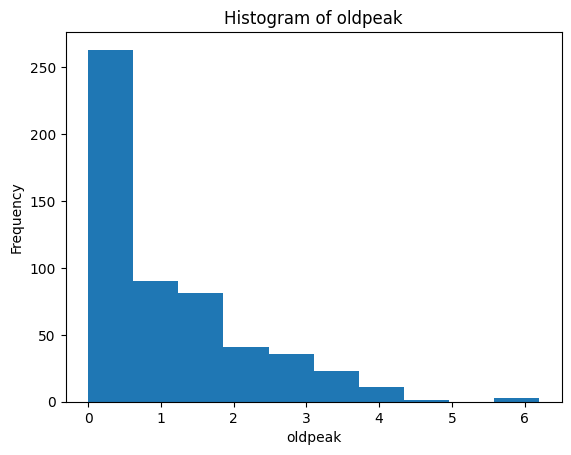

In [ ]:
g101 = feature_stats(df, 'oldpeak')
g102 = feature_histogram(df, 'oldpeak')

In this graphic we observe that it is absolutely one-sided. Which is bad because that means that the model will have it harder to tell if the individual happens to have a 6 in his/her oldpeak value.

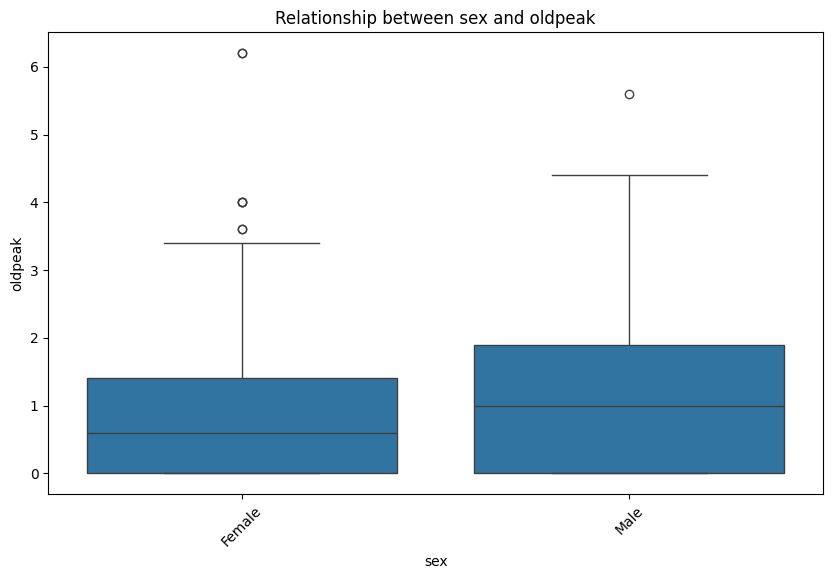

In [ ]:
g103 = features_relationship(df, 'oldpeak', 'sex')

Here we can see that the values are in most cases similar, meaning that when the model tries to tell the genre, this metric won't help a bit.

### SLOPE

Stats of slope: Unique=slope
Downsloping    264
Flat           250
Upsloping       34
Unknown          1
Name: count, dtype: int64 |


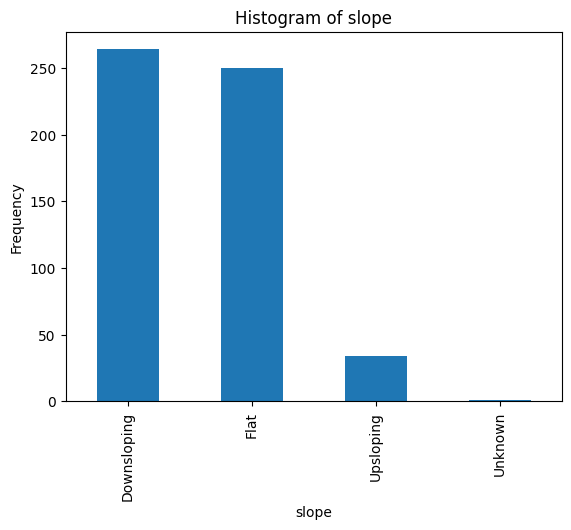

In [ ]:
g111 = feature_stats(df, 'slope')
g112 = feature_histogram(df, 'slope')

There are almost no upsloping cases compared to the other two, that means that we won't know that much when we are presented with one of these cases.

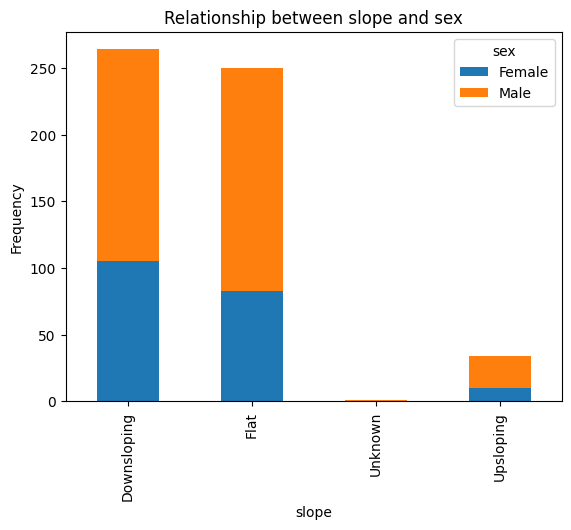

In [ ]:
g113 = features_relationship(df, 'slope', 'sex')

Have in count the fact that we have more males than females, this graphic is pretty balanced, meaning that it won't work in differentiating genres.

### CA

Stats of ca: Min=0 | Max=4 | Mean=0.7049180327868853 | Std=0.961101786872221 |


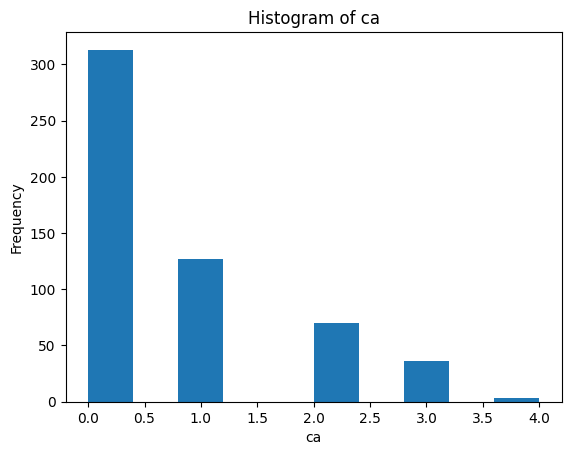

In [ ]:
g121 = feature_stats(df, 'ca')
g122 = feature_histogram(df, 'ca')

The more the ca value increments, the less cases we have. This irregularity brings us to a lack of knownledge in this scenarios.

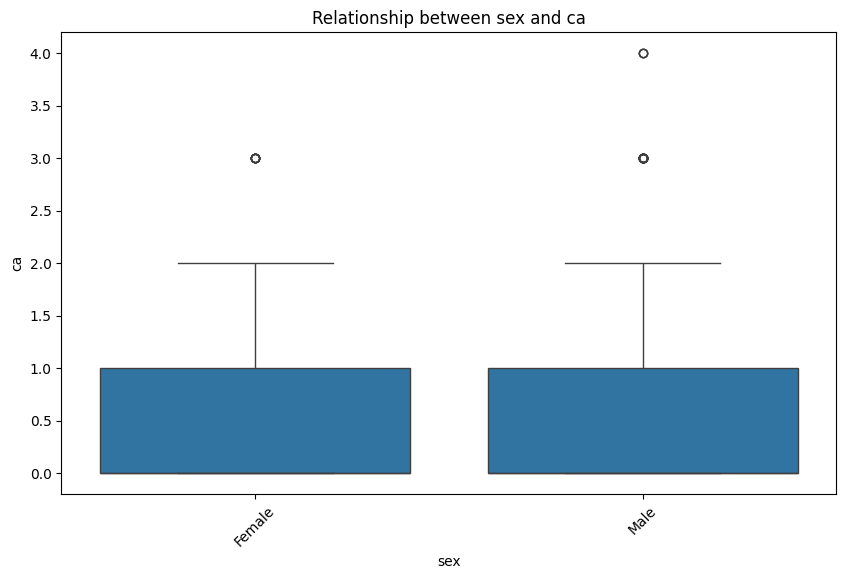

In [ ]:
g123 = features_relationship(df, 'ca', 'sex')

As comented before and shown known, the more extreme cases are rare, therefore harder to differ. Eventhought that previous fact, we could say that if it's near to 4 it is probably a man.

### THAL

Stats of thal: Unique=thal
Reversible defect    258
Type 3               239
Type 7                24
Fixed defect          23
Normal                 3
Type 6                 2
Name: count, dtype: int64 |


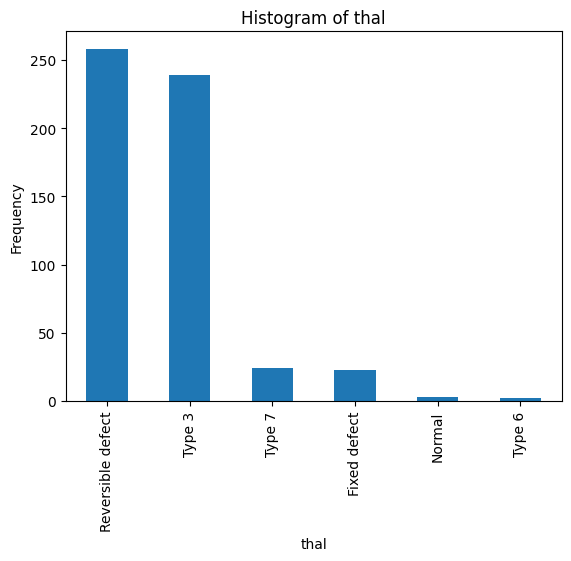

In [ ]:
g131 = feature_stats(df, 'thal')
g132 = feature_histogram(df, 'thal')

In this case, the graphic is unbalanced because we have 6 different categories, but only 2 have a big rate of frequency, the others have small numbers of cases.

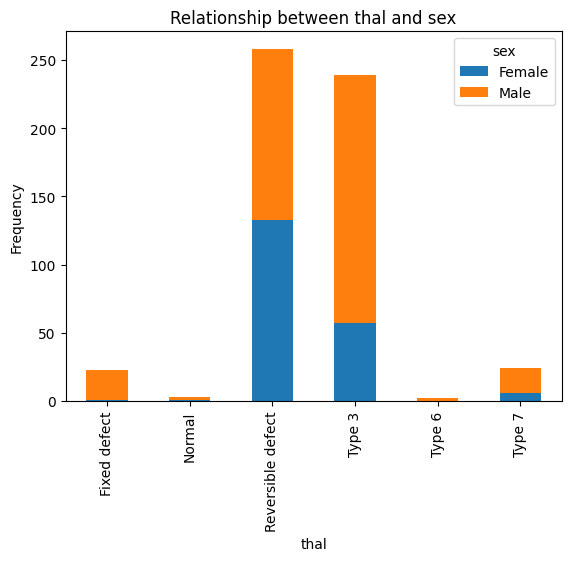

In [ ]:
g133 = features_relationship(df, 'thal', 'sex')

In this graphic we observed the relationship between thal and sex. In only one category do we have the same number of males as females, in others we have significantly more males.

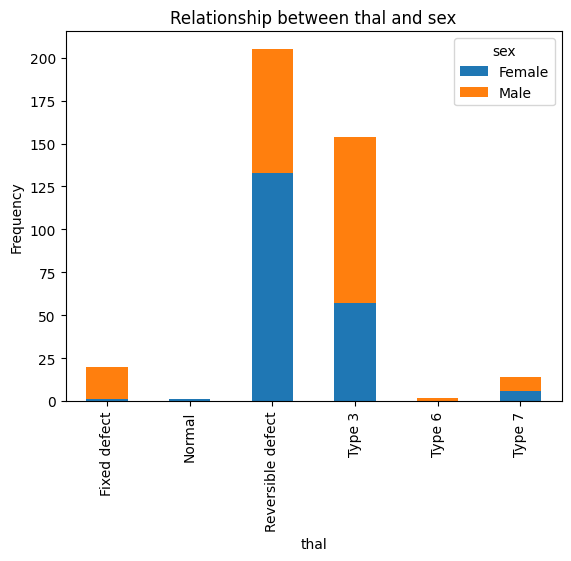

In [ ]:
g133 = features_relationship(df1, 'thal', 'sex')

In the balanced graphic we have similar behaviour. Only in the *Type 7* we have the same number of cases and in *Reversible detect* we have more females.

## Analyze relevant relationships
Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.

In the previous section we saw the relationship of the sex (target class) between the other attributes, but now we will try to find another relationship.

### Relationship AGE and TRESTBPS

In theory, the value of trestbps is higher where you are older.

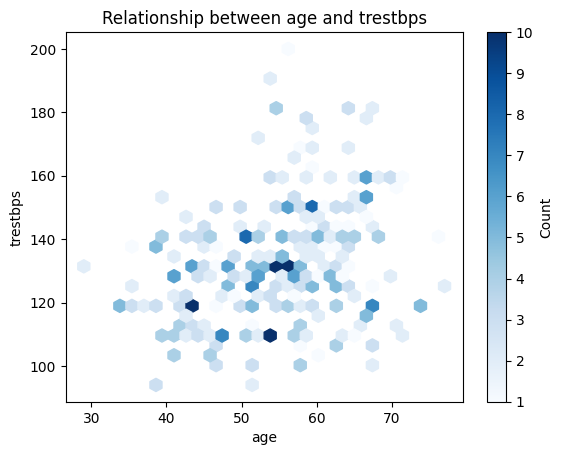

In [ ]:
features_relationship(df, "age", "trestbps")

We can see that our assumption was bad, and this two features are not relationet. In general, the values of trestbps remains relatively constant with increasing age.

### Relationship AGE and THALACHH

In theory, the value of Talach decreases with increasing age.


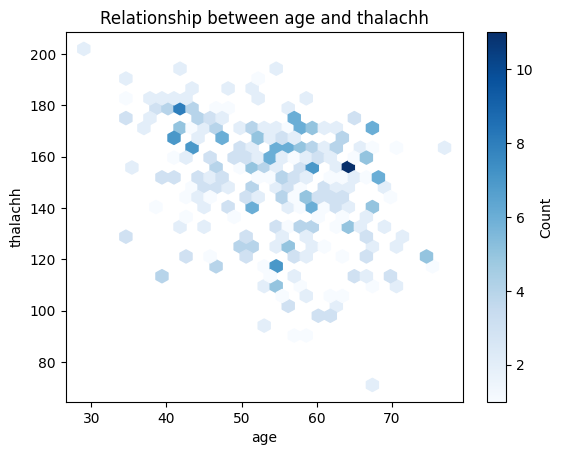

In [ ]:
features_relationship(df, "age", "thalachh")

We can see this decrease in the value of thalachh with increasing age. This decrease is not very strong but is sufficiently notorious.

### Relationship SLOPE and OLDPEAK



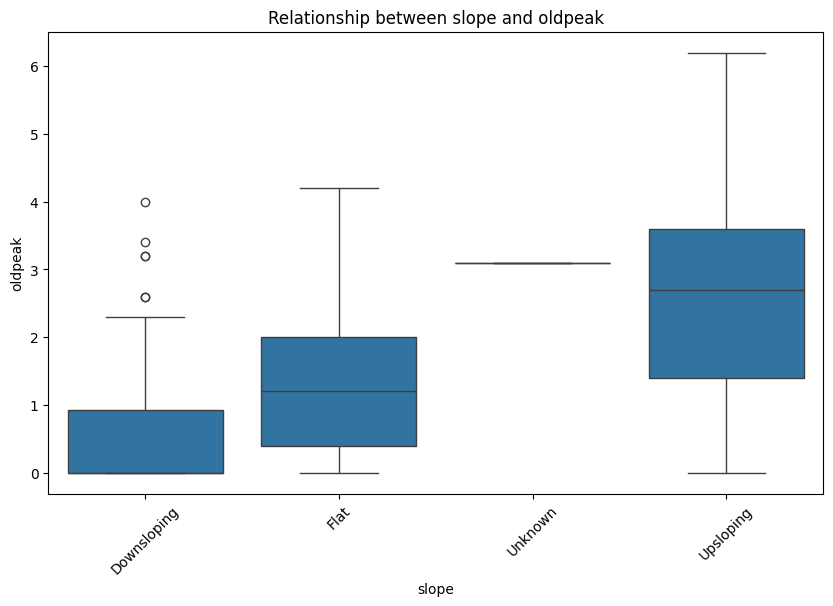

In [ ]:
features_relationship(df, "slope", "oldpeak")

The graphic shows that the values of oldpeak is higher this order of type of slope: downsloping -> flat -> upsloping. SO we can see that his relationship is very strong.

### Relationship AGE and CHOL
The value of chol is increasing with increasing age. This is not true because it depends of the habits of the person, but we can study if it's true.

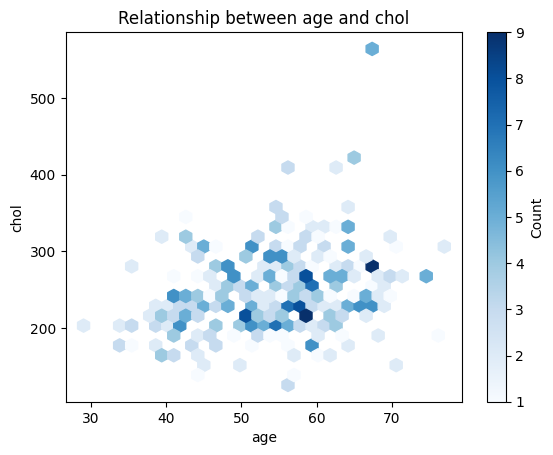

In [ ]:
features_relationship(df, "age", "chol")

We can see a small increase of the chol but it is not very notorious. So we can see that age and chol are related but not very strongly.

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the task. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [ ]:
def preprocessing_0(df):
  preprocessed_df = df.copy()
  # Define columns to use and categorical
  categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
  numerical_cols = ['age', 'trestbps', 'chol', 'thalachh', 'oldpeak', 'ca']
  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)], remainder="passthrough")
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Students cannot use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Model

In [ ]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 232 parameters


## Training

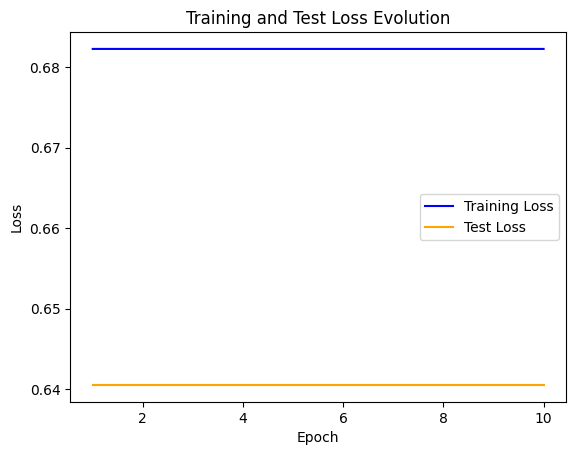

Epoch [10/10] | Training Loss: 0.6823 (starting at 0.6823) | Test Loss: 0.6405 (starting at 0.6405)
CPU times: user 1.41 s, sys: 30.2 ms, total: 1.44 s
Wall time: 1.46 s


In [ ]:
%%time
losses = train(model, train_dataset, test_dataset, num_epochs=10, lr=0.01)

## Evaluation

Train accuracy: 63.10%
Test accuracy: 67.27%


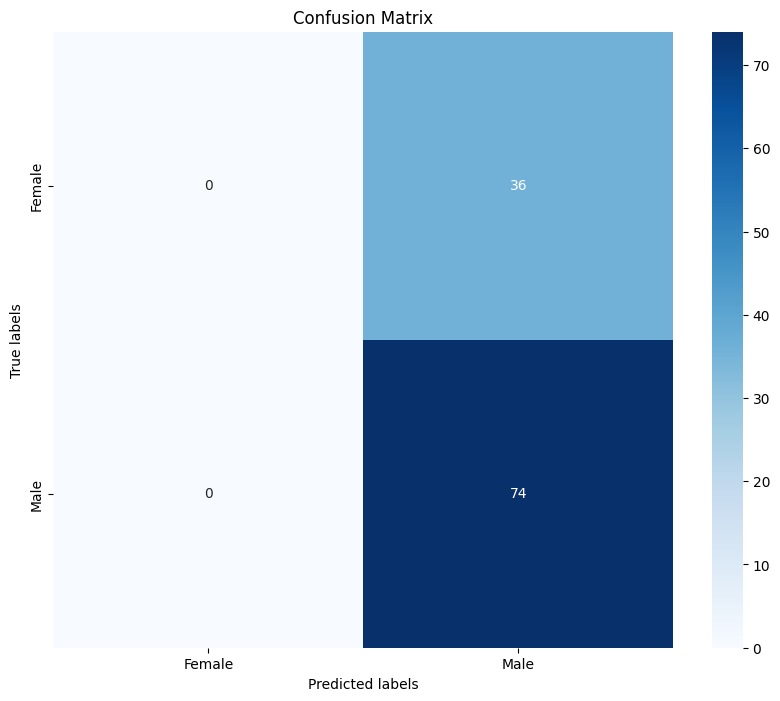

In [ ]:
train_accuracy, test_accuracy, test_all_targets, test_all_predicted = full_evaluation(model, train_dataset, test_dataset, label_encoder)

# <font color='orange'>Student: Experiments</font>
<a name="experiments"></a>

<font color='orange'>In this section, the student will have to create two or three consequent solutions for the **Sex classification task**. Each solution must contain the following components:<font color='orange'>
* **Idea**: Textual explanation of what is the target/reasoning of the solution (e.g., "I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model").
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can **only use Pandas' functions**.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results. This typically implies aiming for convergence.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Textual examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time
</font>

<font color='orange'>It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components.
</font>

<font color='orange'>**An extended analysis of the baseline results is also requested.**
</font>

<font color='orange'>None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.
</font>

<font color='orange'>In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.
</font>

## <font color='orange'>Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instace, which features are used and how.</font>

### Prepocessing Explanation

In the preprocessing of the baseline model, we can see that transforming the categorical attribute to binary vector makes the model process this type of information. So we have a new dataframe with data: 0, 1 and literal values of numerical attributes.
This is bad because we have the binary vector of the categorical attribute and big values of the numerical attributes.

In conclusion, the model gives more importance to numerical values because they are bigger than 0 and 1 and practically doesn't take into account the categorical attributes.

It is important to highlight that when we finish the preprocessing, we use the function df_to_dataset to separate the dataset into a test set and a training set.

### Model Explanation


In this baseline model, we observe that it consists of a single linear layer followed by a Softmax activation. The linear layer maps the input features directly to the output classes. This means each output neuron produces a score corresponding to a specific class.
The Softmax activation function then converts these scores into probabilities, ensuring they sum to 1. This normalization is crucial for classification tasks, as it allows us to interpret the outputs as class probabilities.
Structurally, the model is defined as a Python class that inherits from nn.Module, which is the standard way to define models in PyTorch. Inside the constructor, we define the layer sequence using nn.Sequential. The forward method specifies how the input flows through these layers during inference.

Finally, the model is instantiated using the create_model function, passing the appropriate input size and number of output classes. This prepares the model for training.

### Trainning Analysis

We can observe that we train the baseline model with 10 epochs and 0.01 of learning rate.
In the graphic we see that the models error's remains constant.
This probably happens because we have a small number of epochs and/or the dataset used to train the test was poorly processed (we explain before).

Also, we see that the test error is lower than the training error. Thats means that the results are higher than test dataset. This is unusual because trainning tests must be better. So we can think that the learning rate is hight and the epoch is low.

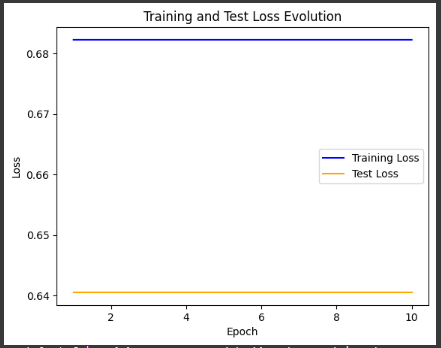

### Acuraccy Analysis

In this case, we obtait the next results: train accuracy 63.10% and test accuracy 67.23%.
It happens that what we said before, the test dataset has more accuracy than training, and this means that something is going wrong in the stage of preprocessing or training.

### Confusion Matrix Analysys


In the confusion matrix we can see the problem of the baseline model. In all of the predictions, it says that the input case is a male.
We know that the database has more male cases and this is why we have these results (above 50%).

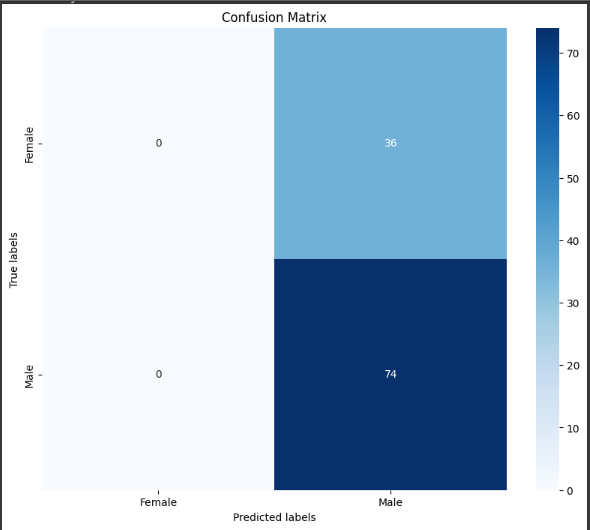

In the confusion matrix we can see the following dates:

*   True Positive (male): 74
*   False Positive (male): 36
*   True Negative (female): 0
*   False Negative (female)e: 0


---


*Accuracity* is the number of well predictions.

*Precision* is the proportion of times the model is correct when it predicts a specific class, such as male or female.

*Recall* is the proportion of actual positive cases (males or females) that the model correctly identifies.

*F-mesure* is a harmonic mean of precision and recall.

---


With this data, we can calculate:

*   Accuracy = (TP + TN) / ALL = (74+0) / 110 = 0.672
*   Precision:
        1.   male = TP / (TP + FP) =  74 / (74+36) = 0.672
        2.   female = TN / (TN + FN) = 0 / (0+0) = error = 0
*   Recall:
        1.   male = TP / (TP + FN) =  74 / (74 + 0) = 1
        2.   female = TN / (TN + FP) = 0 / (0+36) = 0
*   F-mesure: (2 · precision · recall) / (precision + recall)
        1.   male = (2 · 0.672 · 1) / (0.627+1) = 0.826
        2.   female = (2 · 0 · 0) / (0+0) = 0

The results are very unbalanced.

### Training Time Analisys

In this case, we have a small training time because the number of epochs is low, and because the model is simple, we don't have hidden layers.

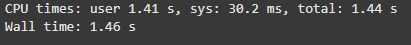

## <font color='orange'>Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.</font>

In [ ]:
# TODO: YOUR CODE HERE
df = data_loading('cleaned_merged_heart_dataset.csv')

In [ ]:
def preprocessing_1B(df):
  preprocessed_df = df.copy()
  # Define columns to use and categorical
  categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
  numerical_cols = ['age', 'trestbps', 'chol', 'thalachh', 'oldpeak', 'ca']
  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  for col in numerical_cols:
    mean = preprocessed_df[col].mean()
    desvitation = preprocessed_df[col].std()
    preprocessed_df[col] = preprocessed_df[col].apply(lambda x: (x-mean)/desvitation)

  # Column transformer of the features
  preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_cols)
  preprocessed_df = preprocessed_df.astype('float64')

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

## <font color='orange'>Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it employs a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.</font>

### Idea

We observed that the teacher solution haven't normalizated numerical atribute. So we normalize the numerical attribute with ragging operation -> (value - min(domain)/(max(domain)-min(domain)))

### Preprocessing

In [ ]:
# TODO: YOUR CODE HERE
def preprocessing_1A(df):
  preprocessed_df = df.copy()
  # Define columns to use and categorical
  categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
  numerical_cols = ['age', 'trestbps', 'chol', 'thalachh', 'oldpeak', 'ca']
  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Normalize the numerical columns
  for col in numerical_cols:
    min = preprocessed_df[col].min()
    max = preprocessed_df[col].max()
    preprocessed_df[col] = preprocessed_df[col].apply(lambda x: (x-min)/(max-min))

  # Column transformer of the features
  preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_cols)
  preprocessed_df = preprocessed_df.astype('float64')

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df1A = preprocessing_1A(df)
train_dataset1A, test_dataset1A, input_size1A, num_classes1A, label_encoder1A = df_to_dataset(preprocessed_df1A)

### Model

In [ ]:
model1A = create_model(Model_0, input_size1A, num_classes1A)

The model has 232 parameters


### Training

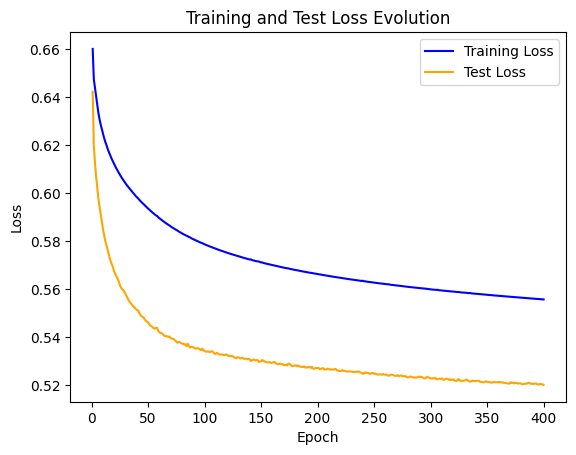

Epoch [400/400] | Training Loss: 0.5557 (starting at 0.6602) | Test Loss: 0.5201 (starting at 0.6423)
CPU times: user 1min 11s, sys: 1.34 s, total: 1min 12s
Wall time: 1min 21s


In [ ]:
%%time
losses1A = train(model1A, train_dataset1A, test_dataset1A, num_epochs=400, lr=0.0065)

### Evaluation

Train accuracy: 76.54%
Test accuracy: 80.00%


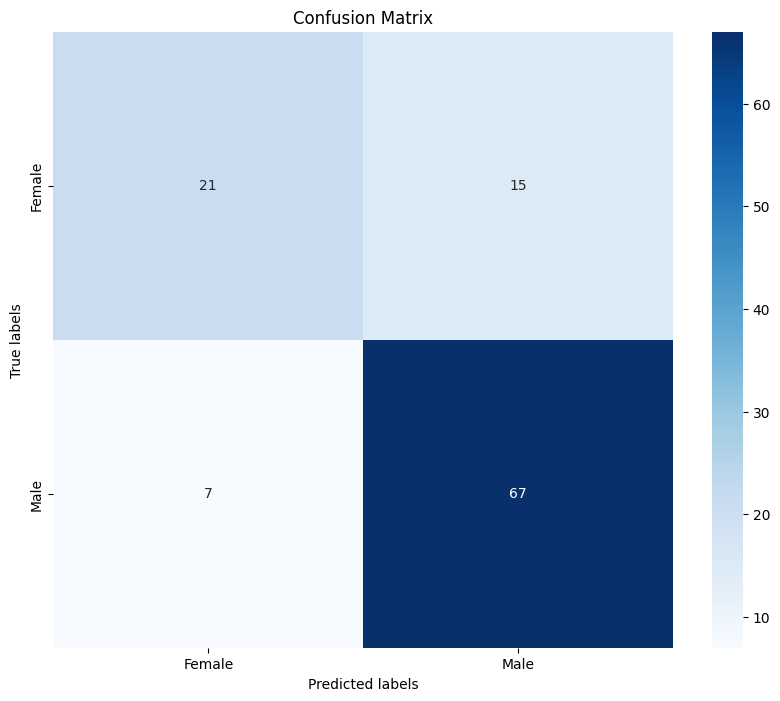

In [ ]:
train_accuracy1A, test_accuracy1A, test_all_targets1A, test_all_predicted1A = full_evaluation(model1A, train_dataset1A, test_dataset1A, label_encoder1A)

In the confusion matrix we can see the following dates:

*   **True Positive** (male): 67
*  **False Positive** (male): 15
*   **True Negative** (female): 21
*   **False Negative** (female)e: 7


---


With this data, we can calculate:

*   Accuracy = (TP + TN) / ALL = (67+21) / 110 = 0.8
*   Precision:
        1.   male = TP / (TP + FP) =  67 / (67+15) = 0.817
        2.   female = TN / (TN + FN) = 21 / (21+7) = 0.75
*   Recall:
        1.   male = TP / (TP + FN) =  67 / (67 + 7) = 0.905
        2.   female = TN / (TN + FP) = 21 / (21+15) = 0.583
*   F-mesure: (2 · precision · recall) / (precision + recall)
        1.   male = (2 · 0.817 · 0.905) / (0.817+0.905) = 0.859
        2.   female = (2 · 0.75 · 0.583) / (0.75+0.583) = 0.656

We can see that the results of the female (negative class) are a little bit low.












### Result Analysis

We **train** the model with the new preprocessing with 400 epochs and a learning rate of 0.0065. We choose this values because we did multiples executions and this values has the best results.
We observed that the training loss gradually decreased and reached an almost constant value, suggesting that the model had converged. The test loss shows small fluctuations, which is expected due to the natural variability in the test data. These results suggest that the chosen learning rate is appropriate.

The **training time** is bigger than before (baseline model), because we use a greater value to epoch.

In this case, we observe the same issue as before: the test dataset shows higher accuracy than the training dataset. After analysing both datasets, we identified an important detail.

The training dataset contains 439 cases (277 males and 162 females), while the test dataset contains 110 cases (74 males and 36 females). This means that females represent only 36.9% of the training set and 32.7% of the test set. These unbalanced cases can negatively affect our model, because we are overtraining the model with male cases.

The **consfusion matrix** supports this observation; the model has approx. 90,5% recall in male cases and 58,3% in female cases.

So we believe this imbalance is the main reason for the lower training accuracy.*The model makes more mistakes in training because has more female percentage cases.*

Let's do a training with a balanced dataset to support this affirmation:


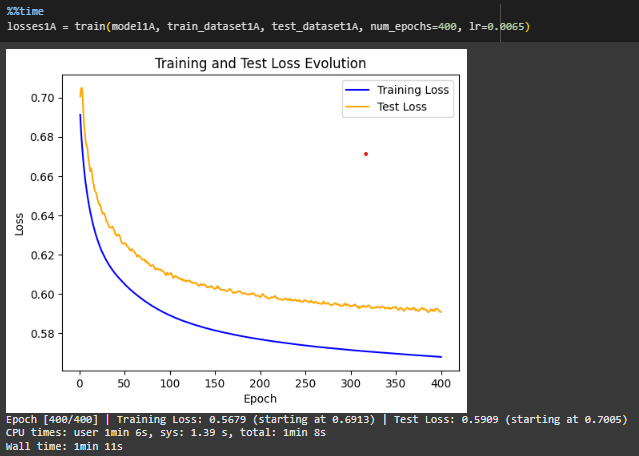

## <font color='orange'>Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative/different preprocessing.</font>

### Idea

We observed that the teacher solution haven't normalizated numerical atribute. So we normalize the numerical attribute with estandarization operation -> (value - mean(domain)/(deviation(domain)))

### Preprocessing

In [ ]:
# TODO: YOUR CODE HERE
preprocessed_df1B = preprocessing_1B(df)
train_dataset1B, test_dataset1B, input_size1B, num_classes1B, label_encoder1B = df_to_dataset(preprocessed_df1B)

### Model

In [ ]:
model1B = create_model(Model_0, input_size1B, num_classes1B)

The model has 232 parameters


### Training

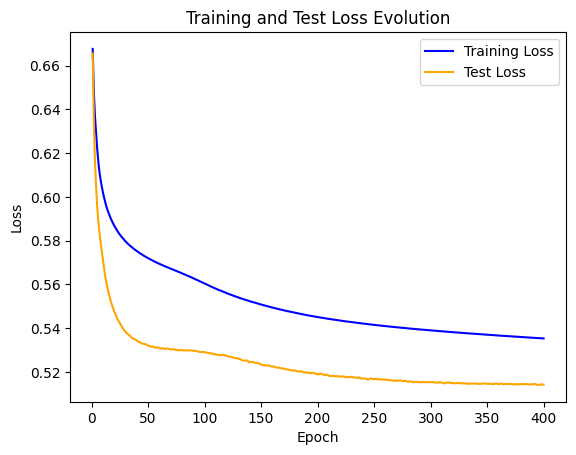

Epoch [400/400] | Training Loss: 0.5353 (starting at 0.6677) | Test Loss: 0.5142 (starting at 0.6655)
CPU times: user 1min 14s, sys: 1.47 s, total: 1min 16s
Wall time: 1min 22s


In [ ]:
%%time
losses1B = train(model1B, train_dataset1B, test_dataset1B, num_epochs=400, lr=0.0065)

### Evaluation

Train accuracy: 78.59%
Test accuracy: 80.00%


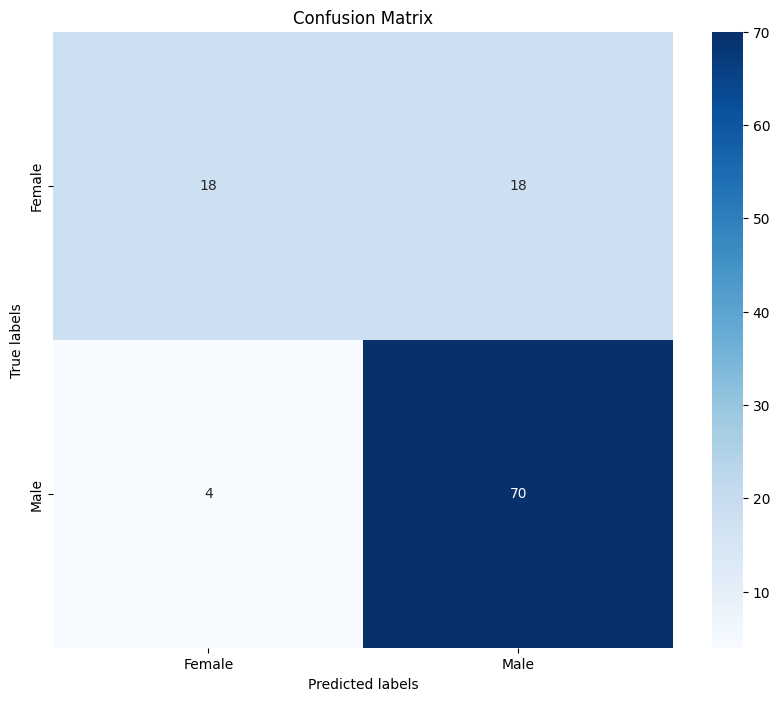

In [ ]:
train_accuracy1B, test_accuracy1B, test_all_targets1B, test_all_predicted1B = full_evaluation(model1B, train_dataset1B, test_dataset1B, label_encoder1B)

In the confusion matrix we can see the following dates:

*   **True Positive** (male): 70
*  **False Positive** (male): 18
*   **True Negative** (female): 18
*   **False Negative** (female)e: 4


---


With this data, we can calculate:

*   Accuracy = (TP + TN) / ALL = (70+18) / 110 = 0.8
*   Precision:
        1.   male = TP / (TP + FP) =  70 / (70+18) = 0.795
        2.   female = TN / (TN + FN) = 18 / (18+4) = 0.81
*   Recall:
        1.   male = TP / (TP + FN) =  70 / (70 + 4) = 0.945
        2.   female = TN / (TN + FP) = 18 / (18+18) = 0.5
*   F-mesure: (2 · precision · recall) / (precision + recall)
        1.   male = (2 · 0.795 · 0.945) / (0.795+0.945) = 0.864
        2.   female = (2 · 0.81 · 0.5) / (0.81+0.5) = 0.618

We can see that the results of the female (negative class) are a little bit low.

### Results analysis

We train the model with the new preprocessing with 400 epochs and a learning rate of 0.0065. We choose this values because we did multiples executions and this values has the best results.

The training time is practically the same than before (solution 1A), because we use the same values.

In this case, we observe the same issue as before: the test dataset shows higher accuracy than the training dataset, but now we know why that happens.


The values of accuracy are the same in this preprocessing as in preprocessing 1A, but male results are better and female results are worse. In this case, the training accuracy is better, so we use this resolution for our model in solution 2 of this project.

## <font color='orange'>Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b). Uses the preprocessing step giving the best results previously but now with an improved MLP model.</font>

## Idea
In this new model, we went one step further and added another layer. The aperation of adding a new layer doesn't improve anything in itself, it's the opperation that we're going to apply to those neuron outputs what is going to improve the success rate.
What we were talking about was activation functions and the main objective here is destroying the lineality. First we will explain why is it that we want it and later how we do it.
Normally in a 1 layer neural network, we will have a linear function, meaning that if we want to separate two different classes, we won't have a clear barrier between those two, so the closer we are to where the barrier is supposed to be, the more confusing things get. On the other hand, if we have a non-linear activation function, we will have a more defined barrier, which makes the decision more clear.
The way we achieve this is by applying some operations to the output of the neuron in order to manipulate the final result. For example, in the ReLU case, if the input is greater than 0, the result stays the same, but if the result is less than 0, the result will be the output multiplied by 0.01.

## Preprocessing

In this model we decided to use the preprocessing from the solution 1B. We simply decided to use the solution that has the best results.

In [ ]:
preprocessed_df2 = preprocessing_1B(df)
train_dataset2, test_dataset2, input_size2, num_classes2, label_encoder2 = df_to_dataset(preprocessed_df2)

## Model


We previously explained the idea behind this new model. Now we will explain the code itself to see which lines of code relate to
the ideas that we talked about. In order to not repeat the explanation from the other model, we will just explain the differences.
Here we have the concept of a new layer, the thing is that, as we explain before, we need an activation function so the new layer
has an actual meaning.

In [ ]:
class Model_2(nn.Module):
    def __init__(self, input_size, num_classes):
        #hidden_size = int(input_size/2)
        hidden_size = int(input_size)
        #hidden_size = int(input_size * 2)
        #hidden_size = int(input_size * 3)
        #hidden_size = int((input_size + num_classes) / 2)
        #hidden_size = int(np.sqrt(input_size * num_classes))
        super(Model_2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

model2 = create_model(Model_2, input_size2, num_classes2)

The model has 3480 parameters


## Training
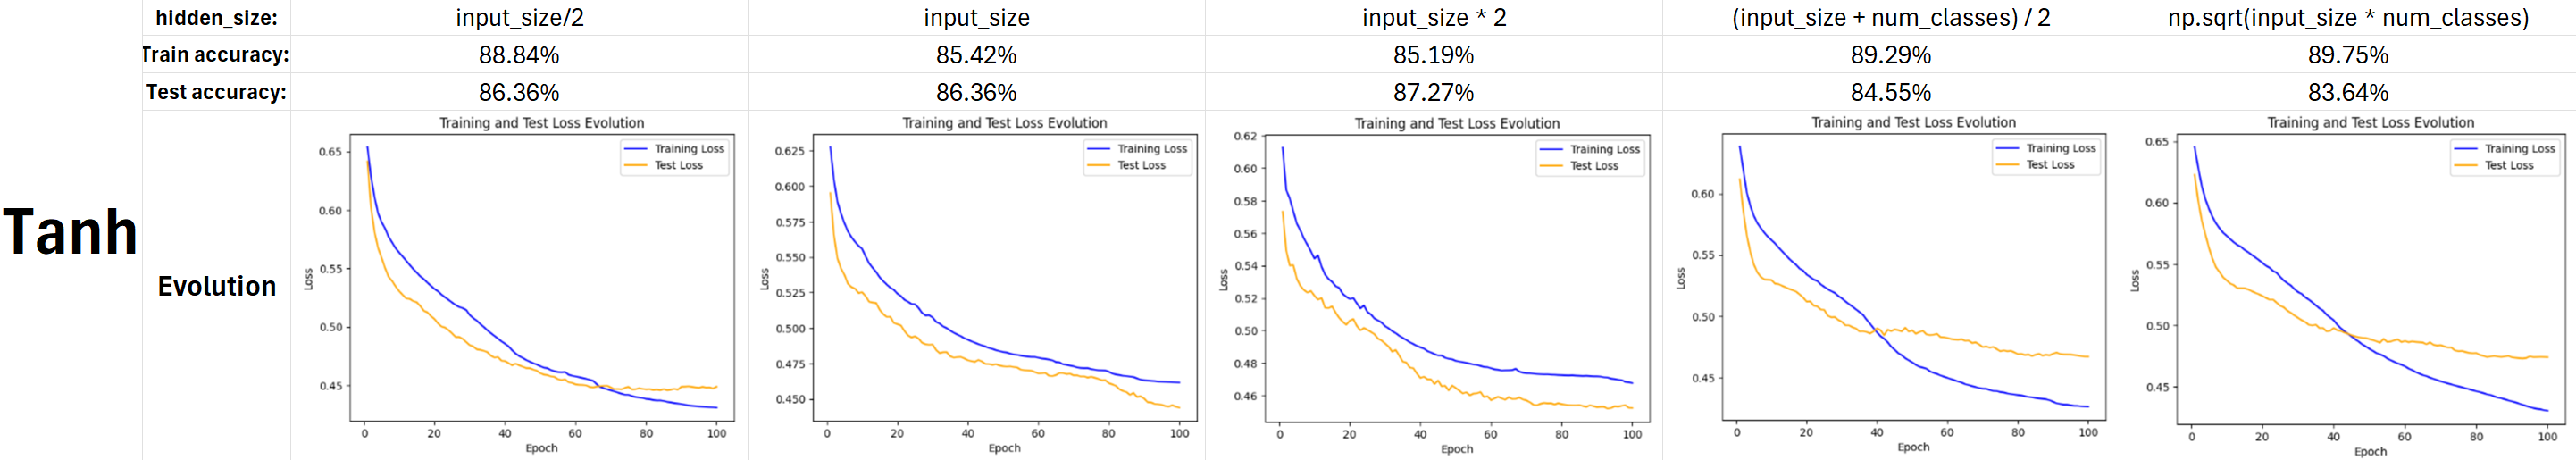
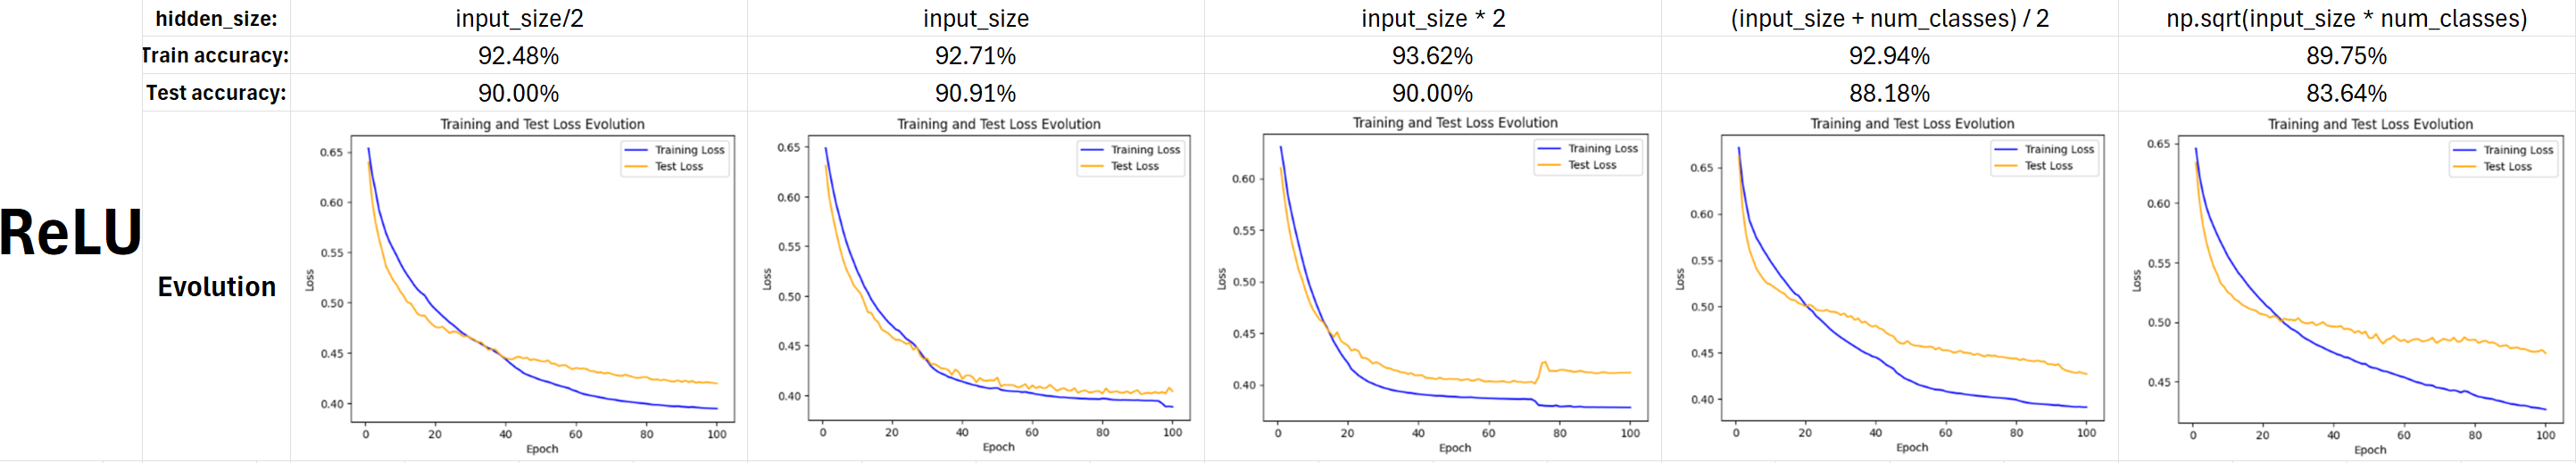


We selected the final model configuration based on both theoretical reasoning and empirical results from multiple experiments. Among the activation functions tested, ReLU outperformed Tanh by achieving faster convergence, lower test loss, and better generalization, with a maximum test accuracy of 91,8%. This is likely due to ReLU’s ability to avoid the vanishing gradient problem and its computational efficiency. For the hidden layer size, setting it equal to the input size provided the best balance between model capacity and overfitting, outperforming both smaller and larger configurations. We also reused the preprocessing pipeline from the best earlier solution to maintain consistency and maximize performance.

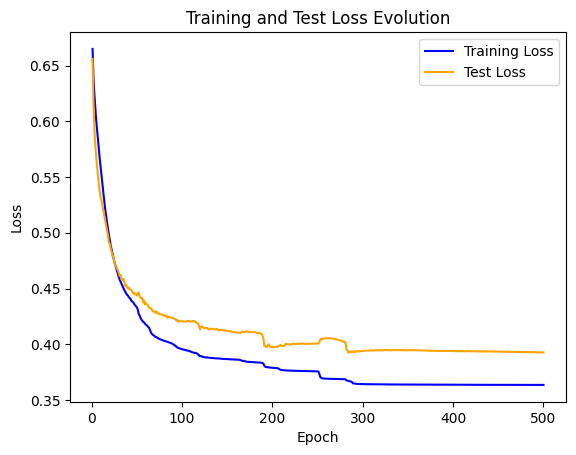

Epoch [500/500] | Training Loss: 0.3635 (starting at 0.6649) | Test Loss: 0.3927 (starting at 0.6558)
CPU times: user 1min 25s, sys: 1.61 s, total: 1min 26s
Wall time: 1min 28s


In [ ]:
%%time
losses2 = train(model2, train_dataset2, test_dataset2, num_epochs=500, lr=0.005)

Regarding training duration, we evaluated model performance with differents values of epochs and learning rates and this is the best result we got.

We can see that the loss value of the test and training sets decreases until it reaches an almost constant value. We observe how the epoch value allows this to happen, and that the learning rate adjusts quite well to what we want.

## Evaluation


Train accuracy: 94.99%
Test accuracy: 91.82%


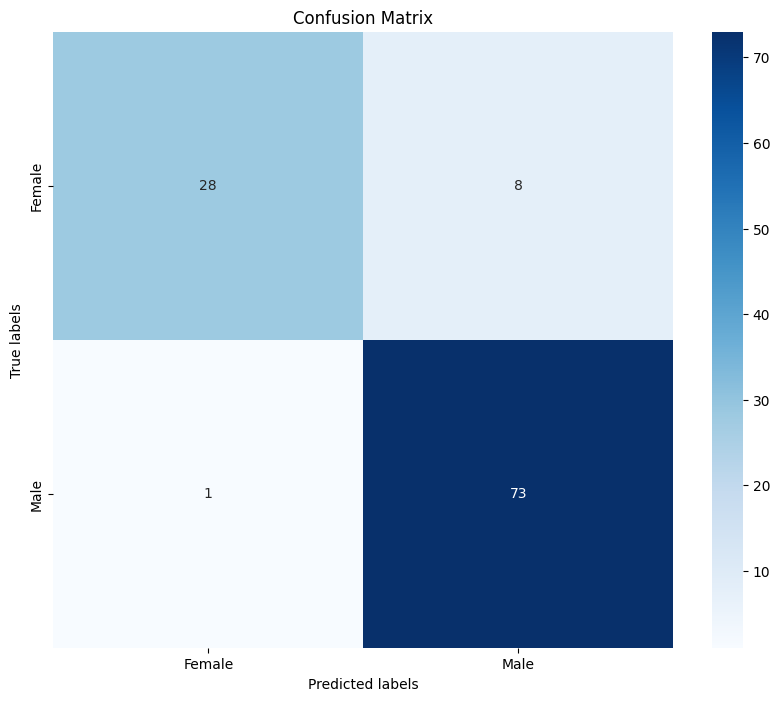

In [ ]:
train_accuracy2, test_accuracy2, test_all_targets2, test_all_predicted2 = full_evaluation(model2, train_dataset2, test_dataset2, label_encoder2)

In the confusion matrix we can see the following dates:

*   **True Positive** (male): 73
*  **False Positive** (male): 8
*   **True Negative** (female): 28
*   **False Negative** (female)e: 1


---


With this data, we can calculate:

*   Accuracy = (TP + TN) / ALL = (73+28) / 110 = 0.918
*   Precision:
        1.   male = TP / (TP + FP) =  73 / (73+8) = 0.901
        2.   female = TN / (TN + FN) = 28 / (28+1) = 0.966
*   Recall:
        1.   male = TP / (TP + FN) =  73 / (73 + 1) = 0.986
        2.   female = TN / (TN + FP) = 28 / (28+8) = 0.78
*   F-mesure: (2 · precision · recall) / (precision + recall)
        1.   male = (2 · 0.901 · 0.986) / (0.901+0.986) = 0.942
        2.   female = (2 · 0.966 · 0.78) / (0.966+0.78) = 0.864

We can see that we improved all the results, above all in the female class (negative), which was the problematic class.

## Results analysis

At the beggining we had a 67.26% of test accuracy and now we have a solid 91,8% so we improved the solution by a lot. This was thanks to the better preprocessing in which we normalized the values and the extra layer in the model with its own activation function, which led to a better sepparation in values, defining then clearer borders between the two genres.

We must say though that despite having a general better performance in our new solution, the baseline solution has a shorter training time due the fact that it doesn't have the extra layer and it doesn't have to do a more complex preprocessing.